# Hierarchical clustering based on semantics, and on syntax

White et al. 2014 asked how much information syntax holds about semantics, and vice versa, by considering English attitude verbs: verbs of mental attitude such as *believe* or *want*, or of communication such as *say* or *claim*.  

They collected data from human participants concerning the semantic similarity among such attitude verbs, and separately collected data concerning the syntactic acceptability of the same attitude verbs in a variety of different syntactic frames.  Using [hierarchical cluster analysis (HCA)](https://en.wikipedia.org/wiki/Hierarchical_clustering), they found a particular clustering of these verbs by semantics, and a similar but not identical clustering by syntax.  You will attempt to replicate those findings, starting from their data, which they kindly [posted online](https://github.com/aaronstevenwhite/ProjectionExperiments) and which have been downloaded for you and included in this homework.

This homework does not cover the maxent modeling part of the same paper.

Many thanks to [Geoff Bacon](https://geoffbacon.github.io/) for writing the first draft of this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, ward
from scipy.spatial.distance import pdist, squareform

### Semantic data

First read in the semantic data, and then perform various sanity checks on it, to see if it matches what is described in the paper.

In [2]:
# read the semantic data into a df.
semantic_fname = "data/triad.preprocessed"
semantic = pd.read_csv(semantic_fname)
semantic.head()

,subj,item,trial,verb0,verb1,verb2,responseindex,response,rt
0,5360a1da64cdc20b3ef9683c2c11a25a,7,1,forbid,remember,demand,1,remember,6585
1,5360a1da64cdc20b3ef9683c2c11a25a,28,2,tell,want,realize,1,want,7328
2,5360a1da64cdc20b3ef9683c2c11a25a,49,3,bother,realize,worry,1,realize,2141
3,5360a1da64cdc20b3ef9683c2c11a25a,70,4,forbid,suppose,demand,1,suppose,3656
4,5360a1da64cdc20b3ef9683c2c11a25a,91,5,amaze,promise,think,1,promise,6562


That looks reassuringly like the top of the file.  The format of each entry is as suggested in the paper, and centers on a triad of words:

- Subject or participant ID
- Item, i.e. stimulus ID
- Trial, i.e. on which trial this participant saw this triad
- Verbs 0, 1, 2: these three verbs constitute the triad
- Response index and response: the word chosen as the odd-one-out in the triad, and its index
- RT, or reaction time.

The top entry holds the triad *forbid*, *remember*, *demand*, and shows that of these, the participant chose *remember* as the odd-one-out, i.e. the verb semantically least like the other two.  RT shows how long it took the participant to determine the odd-one-out, and could therefore also be seen as reflecting similarity, although we won't be using it.

The paper reports (p. 3) that there were:

- 30 attitude verbs
- 4060 triads = every possible triad composed of the 30 verbs.
- 60 participants
- 203 triads per participant

<u>Combinatorial aside</u>: why are there 4060 triads?  Because they constructed every possible triad out of a set of 30 verbs, and the number of ways to select 3 objects out of a set of 30 is:

\begin{equation}
{30 \choose 3} = \frac{30!}{3! (30-3)!} = 
\frac{30!}{3! (27)!} = \frac{30 \times 29 \times 28}{3 \times 2 \times 1} = \frac{24360}{6} = 4060.
\end{equation}

Now that we've read in the data, let's perform a few sanity checks, to see if the numbers of various items in the data line up with those reported in the paper.

In [3]:
# how many verbs are in the data?  white et al. say 30.
v = semantic.verb0.tolist()
v += semantic.verb1.tolist()   # cannot use "append": will produce unhashable type: 'list' error when using set()
v += semantic.verb2.tolist()
all_verbs = list(set(v))

print(all_verbs)
print(len(all_verbs))

['guess', 'see', 'say', 'promise', 'realize', 'bother', 'believe', 'remember', 'tell', 'allow', 'expect', 'forget', 'hate', 'want', 'imagine', 'forbid', 'deny', 'need', 'hope', 'feel', 'demand', 'doubt', 'understand', 'love', 'amaze', 'worry', 'pretend', 'think', 'suppose', 'hear']
30


In [4]:
# how many triads are in the data?  white et al. say 4060.
# DEFINE g APPROPRIATELY.  YOUR CODE GOES HERE.  
g = semantic.groupby(['verb0','verb1','verb2'])

print(len(g.groups))
display(g.get_group(('allow', 'forget', 'hope')))

4060


,subj,item,trial,verb0,verb1,verb2,responseindex,response,rt
10181,58455efa38555a98451258d49346bb05,635,32,allow,forget,hope,2,hope,1331411599190
10384,be1b2fe24ed10dcf6a35d92cc499ad4d,635,32,allow,forget,hope,2,hope,1331413053050
10587,8fe14b267e9d348a8fde8cc27eac4eae,635,32,allow,forget,hope,2,hope,1331413712587


In [5]:
# how many participants, and how many triads per participant?  
# white et al. say 60 participants, with 203 triads per participant.
# DEFINE g APPROPRIATELY.  YOUR CODE GOES HERE.  
g = semantic.groupby('subj')

print(len(g.groups), "participants")
for grp_name in g.groups:
    grp = g.get_group(grp_name)
    print("participant", grp_name, "has", len(grp), "items")

60 participants
participant 03b4e36cd2869d2333ff0b69034e1080 has 203 items
participant 08f328d1a86a151a50c978d9582d6c5d has 203 items
participant 149c64cecc1cec734cb1838a6741877a has 203 items
participant 1b270df1626ad406639c8bc769ef1227 has 203 items
participant 2240f73a2e8ce1b6cb92d42f3cc2208b has 203 items
participant 233a3b4358a3805516ae0934bb4cced4 has 203 items
participant 23d003ce6b9741c5f93a7816e434ea21 has 203 items
participant 26df7abb70f8e1fbd0ff6458a98bfad4 has 203 items
participant 31aa8a96d2c63b98754afe529b3a5a3b has 203 items
participant 3da44c7429fac4a2ea1dd8503a760963 has 203 items
participant 45c6912e87fea39172e04d8db12fc7b8 has 203 items
participant 5360a1da64cdc20b3ef9683c2c11a25a has 203 items
participant 582ea5063f5d3bea44f75ee3d1dd6f9f has 203 items
participant 58455efa38555a98451258d49346bb05 has 203 items
participant 595a4f5dcd80610e4af39ce5340773e2 has 203 items
participant 5ba2d1e9a64ed869ac8989e02d93a4f7 has 203 items
participant 5f09ab68f3d58e871de4241d120b

### Hierarchical clustering of semantic data

Sanity achieved!  The semantic data look fine, at least as far as we've checked.  

So let's move on to cluster them.  The first step is to transform the odd-one-out responses above into a symmetric dissimilarity matrix.  We do this as described in White et al., section 3.1:

> To obtain distances between our verbs from the semantic
similarity judgments described in section 2.1, we simply count the number of times a verb
was chosen as dissimilar from two others in a triad. For each such judgment, we increment the dissimilarity score between that verb and the two others. This provides us with
a symmetric matrix of dissimilarities, which we can think of as representing the distances between verbs.

Note the symmetry stipulation for the matrix.  This means that when we want to increment the dissimilarity between words two words w1 and w2, we should increment both dissimilarity(w1,w2) and dissimilarity(w2,w1).  This means the contents of the matrix are insensitive to the order of the two words.

In [9]:
# set up symmetric matrix to hold dissimilarities.
# indices along each axis will be verbs in the order given by the list all_verbs, from above.
all_verb_pairs = [(v1,v2) for v1 in all_verbs for v2 in all_verbs]
print("there are", len(all_verbs), "verbs")
print("there are", len(all_verb_pairs), "pairs of verbs")
# dissimilarities will be represented as a dict d, with key in the form of a tuple: (verb1,verb2), 
# and value = dissimilarity of verb1 and verb2.
# initialize the dict to all zero entries.
d = {pair: 0 for pair in all_verb_pairs}    # REPLACE - YOUR CODE GOES HERE
# now print out the initialized matrix as a sanity-check.
print("initialized dissimilarity matrix")
for v1 in all_verbs:
    # this odd-looking print statement prints out a list without brackets and commas.
    print(*[d[(v1,v2)] for v2 in all_verbs], sep=' ')

there are 30 verbs
there are 900 pairs of verbs
initialized dissimilarity matrix
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0

In [10]:
# now go through the semantic dataframe and convert each judgment into dissimilarity scores as 
# described in the white et al. excerpt above, and stash those scores in the matrix.

# note: although as a general rule it is terribly unpythonic to iterate through rows in a dataframe,
# sometimes it can be argued that it's the right thing to do.  in this case i think it's the right 
# thing to do because the resulting code is quite clear and easy to understand, and it is not that 
# slow: this block takes 3-4 seconds to execute on my laptop.
for index, row in semantic.iterrows():
    # YOUR CODE GOES HERE - FILL IN THE d MATRIX (dict).
    triad = set([row['verb0'], row['verb1'], row['verb2']])
    one = row['response']
    others = list(triad - set([one]))  # set(one) does not work
    d[(one, others[0])] += 1
    d[(one, others[1])] += 1
    d[(others[0], one)] += 1
    d[(others[1], one)] += 1

# sanity-check: print out the resulting dissimilarity matrix and eyeball it.
# is it symmetric?
# does it still have zeroes on the diagonal?
print("filled dissimilarity matrix")
for v1 in all_verbs:
    # this odd-looking print statement prints out a list without brackets and commas.
    print(*[d[(v1,v2)] for v2 in all_verbs], sep=' ')

filled dissimilarity matrix
0 52 47 62 53 72 50 51 54 62 46 58 75 65 31 70 64 64 45 54 66 35 50 78 65 62 44 36 15 60
52 0 24 60 31 78 38 56 34 58 57 71 78 55 49 73 72 62 65 39 66 72 45 68 60 77 70 43 53 19
47 24 0 36 57 71 54 51 10 51 57 73 80 57 59 70 62 68 63 52 45 71 49 69 69 73 65 52 51 22
62 60 36 0 60 71 42 47 40 41 44 68 71 48 55 55 63 53 29 65 37 70 45 41 50 73 61 64 60 57
53 31 57 60 0 76 29 28 54 54 46 60 73 51 32 77 76 53 49 43 70 64 20 65 47 61 61 25 40 52
72 78 71 71 76 0 70 68 60 67 69 61 32 62 69 42 54 65 68 65 39 41 68 71 66 27 62 68 66 73
50 38 54 42 29 70 0 48 59 63 49 66 76 56 25 64 64 60 28 36 69 57 42 51 34 68 48 25 33 56
51 56 51 47 28 68 48 0 54 60 46 31 70 66 37 77 72 61 57 48 70 66 33 51 56 63 55 38 49 50
54 34 10 40 54 60 59 54 0 47 64 68 76 66 60 58 63 68 74 52 33 71 58 71 66 71 65 50 59 33
62 58 51 41 54 67 63 60 47 0 54 65 72 42 59 52 43 41 59 68 49 64 48 59 61 73 59 68 45 59
46 57 57 44 46 69 49 46 64 54 0 74 72 28 46 64 67 34 35 56 34 63 50 64 52 60 53 53

In [11]:
# so far so good.  let's do a little more sanity-checking.
# sort the elements in the matrix by dissimilarity, and take a look at a few pairs that 
# have been scored highly similar (other than identical words), or highly dissimilar.
# sorted_d is a list containing the items of d, sorted by value.
sorted_d = sorted(d.items(), key=lambda kv: kv[1])  # sort by 2nd item in key-value pair.
sorted_d_no_zeroes = [(pair, score) for (pair,score) in sorted_d if score > 0]
print("20 most similar non-identical pairs:")
print(sorted_d_no_zeroes[:20])
print()
print("20 most dissimilar pairs:")
print(sorted_d_no_zeroes[-20:])

20 most similar non-identical pairs:
[(('say', 'tell'), 10), (('tell', 'say'), 10), (('want', 'need'), 12), (('need', 'want'), 12), (('guess', 'suppose'), 15), (('suppose', 'guess'), 15), (('forbid', 'deny'), 16), (('deny', 'forbid'), 16), (('see', 'hear'), 19), (('hear', 'see'), 19), (('realize', 'understand'), 20), (('understand', 'realize'), 20), (('imagine', 'pretend'), 21), (('pretend', 'imagine'), 21), (('say', 'hear'), 22), (('hear', 'say'), 22), (('doubt', 'worry'), 23), (('worry', 'doubt'), 23), (('see', 'say'), 24), (('say', 'see'), 24)]

20 most dissimilar pairs:
[(('forbid', 'feel'), 77), (('hope', 'forget'), 77), (('feel', 'forbid'), 77), (('doubt', 'hear'), 77), (('worry', 'see'), 77), (('hear', 'doubt'), 77), (('guess', 'love'), 78), (('see', 'bother'), 78), (('see', 'hate'), 78), (('bother', 'see'), 78), (('hate', 'see'), 78), (('hate', 'hear'), 78), (('love', 'guess'), 78), (('hear', 'hate'), 78), (('say', 'hate'), 80), (('hate', 'say'), 80), (('hate', 'suppose'), 80),

So now we have a dissimilarity matrix, and it seems to have more or less reasonable contents.  

That means we are ready for clustering.  White et al. say (p. 4) that they proceeded as follows:

> [W]e apply hierarchical clustering, using Ward’s method as our linkage criterion, to discover semantic
class at different levels of abstraction for both the semantic similarity judgments and the
syntactic compatibility judgments we collected.

It's at this point that we make contact with [hierarchical clustering in scipy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).  As with pandas and sklearn, someone else has done the work of finding reliable ways to carry out an important set of common tasks, and you just need to use these already-written routines.  There are two routines in particular that we will use:

- [ward](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.ward.html): Performs hierarchical clustering using [Ward's method](https://en.wikipedia.org/wiki/Ward%27s_method).
- [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html): Plots the results of hierarchical clustering as a dendrogram.

The first routine, **ward**, takes as input a single argument which is a **condensed distance matrix**.  According to the [documentation for ward](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.ward.html), a condensed distance matrix is "a flat array containing the [upper triangular of the distance matrix](https://en.wikipedia.org/wiki/Triangular_matrix)."  So the main thing we will need to do before invoking ward is to create a simple flat list that contains only the elements in the upper triangular portion of our dissimilarity matrix.  NB: this does not include the diagonal, which is necessarily and therefore uninformatively all zero.

In [20]:
# the first step is to call ward to perform hierarchical clustering using ward's method.
# this requires that we create a simple flat list containing the elements of the upper triangular
# portion of our dissimilarity matrix, as a list.
# get the value of each element of d as we trace over the upper triangle of d:
# the entire top row except for first element, 
# then the next row except for the first two elements, 
# then the next row except for the first three elements, etc.
# NB: we are leaving out the diagonal, which is necessarily and therefore uninformatively all 0s.

# YOUR CODE GOES HERE - CREATE LIST ut WHICH IS UPPER TRIANGULAR PORTION OF DISSIM MATRIX, AS FLAT LIST.
ut = [d[(all_verbs[i],all_verbs[j])] for i in range(len(all_verbs)-1) for j in range(i+1, len(all_verbs))]   # REPLACE - YOUR CODE GOES HERE
print(len(ut))
print(ut)

435
[52, 47, 62, 53, 72, 50, 51, 54, 62, 46, 58, 75, 65, 31, 70, 64, 64, 45, 54, 66, 35, 50, 78, 65, 62, 44, 36, 15, 60, 24, 60, 31, 78, 38, 56, 34, 58, 57, 71, 78, 55, 49, 73, 72, 62, 65, 39, 66, 72, 45, 68, 60, 77, 70, 43, 53, 19, 36, 57, 71, 54, 51, 10, 51, 57, 73, 80, 57, 59, 70, 62, 68, 63, 52, 45, 71, 49, 69, 69, 73, 65, 52, 51, 22, 60, 71, 42, 47, 40, 41, 44, 68, 71, 48, 55, 55, 63, 53, 29, 65, 37, 70, 45, 41, 50, 73, 61, 64, 60, 57, 76, 29, 28, 54, 54, 46, 60, 73, 51, 32, 77, 76, 53, 49, 43, 70, 64, 20, 65, 47, 61, 61, 25, 40, 52, 70, 68, 60, 67, 69, 61, 32, 62, 69, 42, 54, 65, 68, 65, 39, 41, 68, 71, 66, 27, 62, 68, 66, 73, 48, 59, 63, 49, 66, 76, 56, 25, 64, 64, 60, 28, 36, 69, 57, 42, 51, 34, 68, 48, 25, 33, 56, 54, 60, 46, 31, 70, 66, 37, 77, 72, 61, 57, 48, 70, 66, 33, 51, 56, 63, 55, 38, 49, 50, 47, 64, 68, 76, 66, 60, 58, 63, 68, 74, 52, 33, 71, 58, 71, 66, 71, 65, 50, 59, 33, 54, 65, 72, 42, 59, 52, 43, 41, 59, 68, 49, 64, 48, 59, 61, 73, 59, 68, 45, 59, 74, 72, 28, 46,

HCA of semantic data


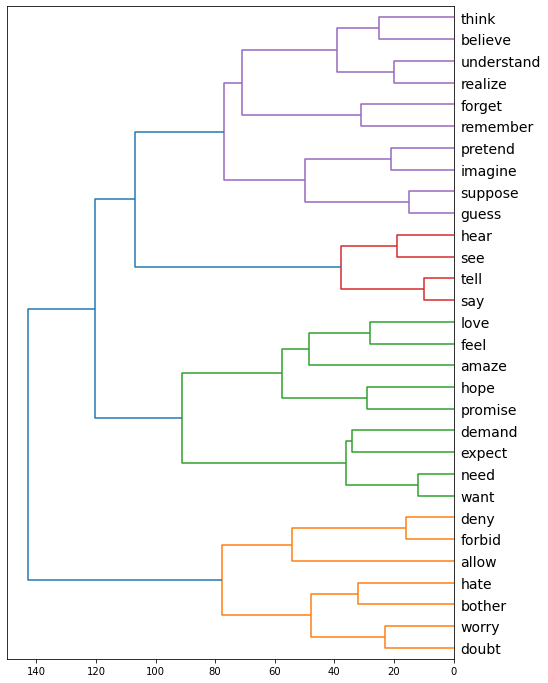

In [21]:
# now feed that upper triangular version of our dissimilarity matrix to ward, and plot the results.
# do HCA using ward's method.
Z = ward(ut)

# and plot the results.
print("HCA of semantic data")
figsize = (8, 12)
fontsize = 14
plt.figure(figsize=figsize)
dendrogram(Z, labels=all_verbs, orientation="left", leaf_font_size=fontsize)
plt.show()

### Syntactic data

As with the semantic data, our first step with the syntactic data is to read in the data, and perform various sanity checks on it, to see if it matches what is described in the paper.

In [22]:
syntactic_fname = "data/frame.filtered"
syntactic = pd.read_csv(syntactic_fname, sep=";")
syntactic.head()

,subj,item,verb,frame,response
0,0146c468fcf6b8ab6de9e102b2bd7ebd,2161,guess,NP Ved about NP,1
1,0146c468fcf6b8ab6de9e102b2bd7ebd,2658,hope,NP Ved about NP,1
2,0146c468fcf6b8ab6de9e102b2bd7ebd,1448,want,NP Ved about NP,1
3,0146c468fcf6b8ab6de9e102b2bd7ebd,2565,understand,NP Ved to VP,1
4,0146c468fcf6b8ab6de9e102b2bd7ebd,610,deny,NP Ved to VP,1


As before, that looks reassuringly like the top of the file.  The format of each entry is:

- Subject or participant ID
- Item, i.e. stimulus ID
- Verb
- Frame: the syntactic frame in which the verb was seen
- Response: acceptability rating for this verb in this frame (1=awful to 7=perfect)

The top entry shows that a specific participant considered a sentence of the form "NP guessed about NP" to be entirely unacceptable.  I personally disagree, but clearly opinions differ.

The paper reports (p. 3) that there were:

- 30 attitude verbs
- 34 syntactic frames
- 1020 = 30 $\times$ 34 combinations of verbs and frames
- 3 sentences per combination, for a total of 3060 items
- 90 participants

Now that we've read in the data, let's perform a few sanity checks, to see if the numbers of various items in the data line up with those reported in the paper.

In [25]:
# how many verbs are in the data?  white et al. say 30.
all_verbs = list(set(syntactic['verb']))   # REPLACE - YOUR CODE GOES HERE.
print(all_verbs)
print(len(all_verbs))

['guess', 'see', 'say', 'promise', 'realize', 'bother', 'believe', 'remember', 'tell', 'hear', 'allow', 'expect', 'forget', 'hate', 'want', 'imagine', 'forbid', 'deny', 'need', 'hope', 'feel', 'demand', 'doubt', 'understand', 'love', 'amaze', 'pretend', 'think', 'suppose', 'worry']
30


In [26]:
# how many syntactic frames are in the data?  white et al. say 34.
all_frames = list(set(syntactic['frame']))  # REPLACE - YOUR CODE GOES HERE.
print(all_frames)
print(len(all_frames))

['NP Ved WH to VP', 'It Ved NP to VP', 'NP Ved VP', 'NP Ved WH S', 'NP Ved NP NP', 'NP Ved NP S', 'NP Ved for NP to VP', 'NP Ved NP that S', 'NP Ved that S', 'NP Ved', 'NP Ved there to VP', 'NP Ved VPing', 'NP Ved S', 'NP Ved NP', 'It Ved NP WH S', 'S, I V', 'NP Ved NP about NP', 'NP Ved to NP that S', 'S, NP Ved', 'NP Ved it that S', 'NP Ved to', 'NP Ved if S', 'NP Ved NP to VP', 'It Ved NP that S', 'It Ved NP WH to VP', 'NP was Ved to VP', 'NP Ved about NP', 'NP Ved to VP', 'NP was Ved that S', 'NP Ved so']
30


In [27]:
# how many participants?  white et al. say 90.
all_Ps = list(set(syntactic['subj']))  # REPLACE - YOUR CODE GOES HERE.
print(len(all_Ps))

86


Things aren't panning out quite as cleanly this time.  Both the number of frames and the number of participants are off a bit.  This is enough to raise the suspicion that we might have the wrong data file - but I did not find anything obviously more appropriate, so let's stick with this one: it's also possible that some data and participants were dropped from the analysis without that being noted in the paper.  These slightly discrepant numbers mean that we are necessarily aiming for merely approximate replication.  For this reason we'll skip the [ridit transformation](https://en.wikipedia.org/wiki/Ridit_scoring) and the (under-described in any event) item correction that White et al. refer to on p. 3, and just treat the data as we find them.

White et al. created their syntactic dissimilarity matrix as follows:

> [The acceptability] scores were then averaged, resulting in one
score for each verb-construction pair—34 scores per verb. (p. 3)

> To obtain distances between our verbs from the syntactic compatibility judgments, we can
think of each verb as a point with 34 dimensions—one dimension for each of our 34 syntactic constructions. We can then take the Minkowski (k = 3) distance between each verb and each other verb, resulting in a dissimilarity (distance) matrix with the same dimensions as the semantic similarity matrix. (pp. 5-6)

Note that since we only found 30 constructions rather than 34 as White et al. report, we will have 30 scores per verb, and correspondingly each verb will be a point in a 30-dimensional space.

So our first step, as before, will be creating the dissimilarity matrix, this time as described above.  To do this, you may want to use groupby in Pandas - we have already used it briefly but if you want a refresher or more detail, here is a [pretty thorough overview](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html).

In [28]:
# start by averaging each verb-construction score across participants
# to do this, start by grouping our syntactic df by verb and frame.
# then look at the resulting groups, to orient yourself.
# note that gb.groups is a dict: the key is the group name, and the value is a list of df indices
# for the df rows belonging to the group.  these refer back to the original df, syntactic.

# DEFINE gb APPROPRIATELY HERE.  YOUR CODE GOES HERE.  
gb = syntactic.groupby(["verb","frame"])
gb.groups

{('allow',
  'It Ved NP WH S'): Int64Index([1906, 1995, 2987, 4787, 5147, 5596, 6406, 6945, 7576], dtype='int64'),
 ('allow',
  'It Ved NP WH to VP'): Int64Index([23, 562, 741, 1283, 4972, 5062, 5333, 6592, 6861], dtype='int64'),
 ('allow',
  'It Ved NP that S'): Int64Index([104, 2173, 3344, 4063, 4512, 5503, 6494, 7032], dtype='int64'),
 ('allow',
  'It Ved NP to VP'): Int64Index([468, 1188, 1460, 3708, 4248, 5419, 6770, 7218, 7400], dtype='int64'),
 ('allow',
  'NP Ved'): Int64Index([512, 1230, 3750, 4290, 4471, 5460, 6000, 7441, 7711], dtype='int64'),
 ('allow',
  'NP Ved NP'): Int64Index([1127, 1576, 2836, 2925, 3827, 5896, 6707, 7155], dtype='int64'),
 ('allow',
  'NP Ved NP NP'): Int64Index([774, 865, 1315, 1764, 2664, 5094, 6176, 7344, 7524], dtype='int64'),
 ('allow',
  'NP Ved NP S'): Int64Index([409, 950, 1038, 1398, 2120, 2390, 3109, 3469, 5270], dtype='int64'),
 ('allow',
  'NP Ved NP about NP'): Int64Index([148, 689, 1949, 2217, 3567, 4107, 4828, 4919, 6988], dtype='int64'

In [30]:
# to further orient ourselves, let's look at one of those groups, 
# the one with key ('allow', 'It Ved NP WH S').

# YOUR CODE GOES HERE.
gb.get_group(('allow', 'It Ved NP WH S'))

,subj,item,verb,frame,response
1906,3726afbd7401ecedb630c09d8525a44d,1637,allow,It Ved NP WH S,1
1995,372b7dce341b6e21d4b3d56c23f37acb,559,allow,It Ved NP WH S,1
2987,5aa04022d58688481f0b8fbd3944cc4d,559,allow,It Ved NP WH S,1
4787,b120b26fe5d9e4f3beb285dc48e48533,1637,allow,It Ved NP WH S,2
5147,ba93fbc5a5bbe75b72609d99e2036add,559,allow,It Ved NP WH S,2
5596,c1178d0ac9f6479fae3209907d49c053,586,allow,It Ved NP WH S,2
6406,db6203f47b4542dff2b65fdf04f3fc06,586,allow,It Ved NP WH S,3
6945,ef68e3ce9580f8f0fa57f37dd23bf2f1,1637,allow,It Ved NP WH S,1
7576,fd601dbd4d6c692e5755a9db9a3594a0,586,allow,It Ved NP WH S,3


In [31]:
# for each group like this, we want the average response.
# let's start by getting all responses for the specific group we just viewed above.

# YOUR CODE GOES HERE.
gb.get_group(('allow', 'It Ved NP WH S'))['response']

1906    1
1995    1
2987    1
4787    2
5147    2
5596    2
6406    3
6945    1
7576    3
Name: response, dtype: int64

In [32]:
# now let's average those together to get the average response for this specific group.

# YOUR CODE GOES HERE.
gb.get_group(('allow', 'It Ved NP WH S'))['response'].mean()

1.7777777777777777

In [33]:
# now generalize what we just did: i.e. apply that same manipulation to all groups, not just one.

# YOUR CODE GOES HERE.
gb['response'].mean()

verb   frame             
allow  It Ved NP WH S        1.777778
       It Ved NP WH to VP    1.555556
       It Ved NP that S      1.125000
       It Ved NP to VP       5.444444
       NP Ved                4.222222
                               ...   
worry  NP Ved to VP          2.000000
       NP was Ved that S     6.333333
       NP was Ved to VP      3.222222
       S, I V                3.125000
       S, NP Ved             4.500000
Name: response, Length: 900, dtype: float64

In [34]:
# length 900: that's reassuring, because 30 verbs * 30 frames = 900.
# and we're getting the same answer for the item we checked by itself.  so that's good.
# now let's put this back in the familiar form of a dataframe.

# YOUR CODE GOES HERE.
gb['response'].mean().to_frame()

response
verb  frame                       
allow It Ved NP WH S      1.777778
      It Ved NP WH to VP  1.555556
      It Ved NP that S    1.125000
      It Ved NP to VP     5.444444
      NP Ved              4.222222
...                            ...
worry NP Ved to VP        2.000000
      NP was Ved that S   6.333333
      NP was Ved to VP    3.222222
      S, I V              3.125000
      S, NP Ved           4.500000

[900 rows x 1 columns]

In [35]:
# that's a df but with a multi-index - let's flatten this out so it has 
# the more familiar standard format.

# DEFINE avg_ratings APPROPRIATELY HERE.  YOUR CODE GOES HERE.  
avg_ratings = gb['response'].mean().to_frame().reset_index()
avg_ratings

,verb,frame,response
0,allow,It Ved NP WH S,1.777778
1,allow,It Ved NP WH to VP,1.555556
2,allow,It Ved NP that S,1.125000
3,allow,It Ved NP to VP,5.444444
4,allow,NP Ved,4.222222
...,...,...,...
895,worry,NP Ved to VP,2.000000
896,worry,NP was Ved that S,6.333333
897,worry,NP was Ved to VP,3.222222
898,worry,"S, I V",3.125000


In [37]:
# now turn this into a matrix with rows = verbs, columns = syntactic frames.
# we will use pivot, which we used before to create a heatmap for color foci.

# DEFINE m APPROPRIATELY HERE.  YOUR CODE GOES HERE.  
m = avg_ratings.pivot(index="verb", columns="frame")
m

response                                                      \
frame      It Ved NP WH S It Ved NP WH to VP It Ved NP that S It Ved NP to VP   
verb                                                                            
allow            1.777778           1.555556         1.125000        5.444444   
amaze            5.750000           2.625000         5.888889        4.333333   
believe          1.222222           1.555556         1.444444        2.000000   
bother           4.111111           2.444444         6.875000        6.000000   
demand           1.333333           1.000000         1.500000        1.333333   
deny             1.375000           1.875000         1.250000        1.333333   
doubt            1.500000           1.500000         2.222222        1.750000   
expect           1.250000           1.000000         1.625000        2.500000   
feel             1.444444           1.444444         1.333333        1.333333   
forbid           1.111111           2.375000         1.333333        3.555556   
forget           1.555556           1.222222         1.500000        1.222222   
guess            1.333333           1.125000         1.111111        1.000000   
hate             1.375000           1.444444         1.444444        1.375000   
hear             1.222222           1.375000         1.222222        1.333333   
hope             1.111111           1.000000         1.111111        1.500000   
imagine          1.222222           1.000000         1.111111        1.375000   
love             1.333333           1.555556         1.625000        1.555556   
need             1.375000           1.555556         1.333333        3.444444   
pretend          1.333333           1.500000         1.333333        1.777778   
promise          1.375000           1.555556         1.666667        1.875000   
realize          1.444444           1.250000         1.111111        1.666667   
remember         1.333333           1.375000         1.250000        1.625000   
say              1.000000           1.222222         1.777778        1.222222   
see              1.500000           1.555556         1.125000        1.888889   
suppose          1.111111           1.444444         1.500000        1.375000   
tell             4.500000           4.111111         4.666667        4.750000   
think            1.555556           1.222222         1.625000        1.111111   
understand       1.625000           1.375000         1.666667        1.222222   
want             1.777778           1.444444         1.555556        3.500000   
worry            4.625000           3.111111         6.500000        3.750000   

                                                                            \
frame         NP Ved NP Ved NP NP Ved NP NP NP Ved NP S NP Ved NP about NP   
verb                                                                         
allow       4.222222  4.500000     3.111111    2.222222           2.000000   
amaze       3.444444  2.222222     1.250000    1.888889           5.000000   
believe     7.000000  5.000000     1.222222    1.777778           6.625000   
bother      4.777778  4.375000     1.666667    2.444444           6.625000   
demand      3.111111  6.888889     2.000000    2.375000           2.000000   
deny        3.888889  3.375000     5.666667    1.222222           2.375000   
doubt       4.750000  2.666667     1.500000    2.000000           4.500000   
expect      4.111111  5.888889     1.444444    2.000000           1.555556   
feel        3.222222  5.666667     2.375000    1.625000           1.222222   
forbid      6.111111  3.888889     2.666667    2.000000           2.222222   
forget      7.000000  6.875000     1.444444    1.555556           1.777778   
guess       6.500000  4.222222     1.375000    1.777778           1.555556   
hate        3.500000  6.888889     1.000000    2.125000           2.555556   
hear        6.111111  5.500000     2.000000    1.500000           2.888889   
hope        5.750

Recall from above that White et al.'s first step in creating their syntactic dissimilarity matrix was:

> [The acceptability] scores were then averaged, resulting in one
score for each verb-construction pair—34 scores per verb. (p. 3)

We have now done that, and can move on to their next step, which is converting this into a verb x verb dissimilarity matrix, based on the representations above - except of course that we have 30 frames not 34.  They did that as follows:

> To obtain distances between our verbs from the syntactic compatibility judgments, we can
think of each verb as a point with 34 dimensions—one dimension for each of our 34 syntactic constructions. We can then take the Minkowski (k = 3) distance between each verb and each other verb, resulting in a dissimilarity (distance) matrix with the same dimensions as the semantic similarity matrix. (pp. 5-6)

Again we can let others do some of the heavy lifting for us.  Note that [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) computes "[p]airwise distances between observations in n-dimensional space", which is exactly what we need.  And in calling pdist, one can specify that the metric to use is Minkowski distance, of order $p=3$.  The icing on the cake is that pdist returns "a condensed distance matrix", which is just the format we need for input to ward.

In [38]:
# get a condensed syntactic dissimilarity matrix.
# let's see if it's the same length as the one we created above, for semantics, called ut.
csd = pdist(m, metric='minkowski', p=3)
len(csd)

435

HCA of syntactic data


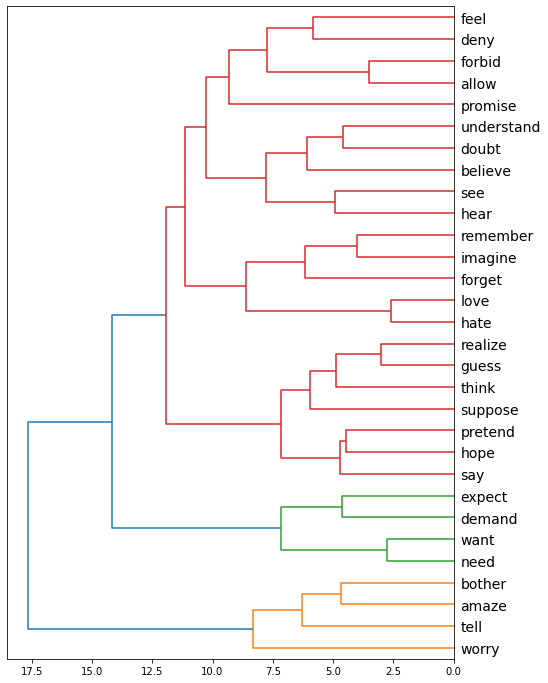

In [39]:
# now do HCA as before, and plot.
# do HCA using ward's method.
Z = ward(csd)

# and plot the results.
print("HCA of syntactic data")
figsize = (8, 12)
fontsize = 14
plt.figure(figsize=figsize)
dendrogram(Z, labels=list(m.index), orientation="left", leaf_font_size=fontsize)
plt.show()

# Observations and conclusions

- Write your general observations about the results here, including the match and/or deviation from the results of White et al., and any conclusions you can draw from those observations.  A short paragraph would be fine, but please separately specify observations and conclusions.

##### Observations:
- For semantic clusterings, the verbs are mainly clustered into three big groups, among which two groups match White et al.'s findings -- the "want" group (e.g., amaze, demand, hope, etc.) and the "think" group (e.g., say, guess, remember, etc.). The remaining cluster does not match White et al.'s result exactly due to the inclusion of "allow" (originally in the "want" group) in this group in our result.
- Syntactic clusterings have relatively larger differences between our results and White et al.'s. Our result does not replicate the "want" and "think" distinction obtained by White et al., though the remaining cluster (worry, tell, amaze, bother) does replicate. In our results, more than half of the "want" group (hate, love, promise, deny, allow, forbid) in White et al.'s result is moved into the original "think" group, forming a broader non-desire mental representation cluster.
- On a higher level, the semantic clustering result replicates White et al.'s result better than then syntactic clustering result. On a lower level, the clusters of 4-5 items are largely replicated. 

##### Conclusions:
- There is a similar "think" and "want" distinction for semantic and syntactic clustering in White et al.'s result, but not so much in ours, suggesting that in this particular case, semantics and syntax do not provide rich high-level information for each other.
- But on a more fine-grained level, there are still overlaps between small semantic clusters and syntactic clusters.

# Extensions (optional)

- Any further exploration with the same datasets that occurs to you, by way of probing the central question posed by White et al.: to what exent does syntax carry information about semantics, and vice versa?  
- Or for that matter, if you'd like to use the same data to probe a different question of your own, feel free.